#LAB 06




# Prerequisite
* Load required packages and load images (already uploaded on BlackBoard) in Colab
* Create your own copy of notebook and add required code snippets in between the questions subsections. Also display the figures at each stage.
*Submit the solution to BlackBoard by Feb 25, 2024 in **.ipynb** format.
*Colab can be exported as a notebook file or Python file by **File > Download .ipynb** or **File > Download .py**. Exported notebook files can be reloaded into Google Colab or used in Jupyter Notebook.
* Please go through [Colab document](https://colab.research.google.com/drive/1YKHHLSlG-B9Ez2-zf-YFxXTVgfC_Aqtt) for further information.

* **Use ONLY basic numpy and Tensorflow functions**

In [1]:
!pip install imagecodecs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 19.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
from scipy import ndimage as nd
from scipy import interpolate as inter
from matplotlib import pyplot as plt
import imagecodecs
import imageio.v2 as imageio
import cv2 as cv
import time

In [3]:
def make_noisy(noise_typ,image):
   if noise_typ == "gauss": #Gaussian Noise
      row,col = image.shape
      mean = 0
      #var = 0.05
      #sigma = var**0.5
      intensity_range = image.max()-image.min()
      sigma = 0.1*intensity_range # This is 5% noise
      gauss = np.random.normal(mean,sigma,(row,col))
      gauss = gauss.reshape(row,col)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p": # Salt and Pepper Noise
      row,col  = image.shape
      s_vs_p = 0.5
      amount = 0.7 # 0.004
      noisy = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = tuple([np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape])
      noisy[coords] = 1 # adding random white pixels

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = tuple([np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape])
      noisy[coords] = 0 # adding random black pixels
      return noisy

#Q1)[**20 points**] Edge-Preserving smoothing using Bilateral Filtering   

<p align="justify"> <b>Download the 'barbara.tif'</b> from BlackBoard. Assume the pixel dimensions to be equal along both axes, i.e., assume an aspect ratio of 1:1 for the axes. <b>Corrupt the image</b> with independent and identically-distributed additive zero-mean Gaussian noise with standard deviation set to 10% of the intensity range.(Use function `make_noisy(noise_typ,image)`) </p>
<p>
<b>Write code for bilateral filtering</b> (standard “slow” algorithm is also fine) and apply it (one pass over all pixels) to the downloaded image. For efficiency in NumPy-Tensoflow, the code should, ideally, have NO `for` loops to go over the rows and columns of the image, ALL code should be vectorized properly. At a specific pixel “p”, the data collection with a window, weight computations, and weighted averaging can be performed without using loops. Your function should be similar input and produce similar output like this <a href="https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed">opencv bilateral function</a>. $[I_{filtered}]= BilateralFilter(I_{corrupted}, W_{size}, \sigma_{intensity},\sigma_{space})$

In [4]:
def bilateral_filter(corrupt_img, window_size, intensity_domain, spatial_domain):
    # vectorized code with no loops, np.apply_along_axis() or np.vectorize()
    window_shape = (corrupt_img.shape[0] - window_size + 1, corrupt_img.shape[1] - window_size + 1, window_size, window_size)
    windows = np.lib.stride_tricks.as_strided(corrupt_img, shape=window_shape, strides=(corrupt_img.strides + corrupt_img.strides))

    reshaped_windows = windows.reshape((windows.shape[0] * windows.shape[1], window_size * window_size))

    centres = reshaped_windows[:, reshaped_windows.shape[1] // 2]
    intensity_weights = np.exp(-((centres[:, None] - reshaped_windows) / (2 * intensity_domain)) ** 2)

    spatial_indices = np.indices((window_size, window_size)).reshape(2, window_size * window_size)
    spatial_weights = np.exp(-np.sum(np.power(spatial_indices, 2), axis=0) / (2 * spatial_domain) ** 2)

    weights = intensity_weights * spatial_weights

    weighted_avg = np.average(reshaped_windows, axis=1, weights=weights)

    filtered_img = np.reshape(weighted_avg, windows.shape[:2])
    # add padding to retain border pixels lost while creating windows
    final_img = np.pad(filtered_img, (corrupt_img.shape[0] - filtered_img.shape[0]) // 2, mode="edge")

    return final_img

<p>Define the root-mean-squared difference (RMSD) as the square root of the average, over all
pixels, of the squared difference between a pixel intensity in the original image and the intensity
of the corresponding pixel in the filtered image, i.e., given $2$ images $A$ and $B$ with $N$ pixels each.</p>
$RMSD(A,B) = \sqrt{\frac{1}{N}\sum_{p}(A(p)-B(p))^2}$, where $A(p)$ is intensity of pixel $p$ on image $A$.

Tune the parameters (standard-deviations for Gaussians over space and intensity) to minimize the RMSD between the filtered and the original image.</p>

##(a)[**0 Points**] Show Original Image.


In [5]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

Original Data_type is float64
Data_type is float64
Image Size is (512, 512)
Image min and max are (6.9993, 240.97589999999997)


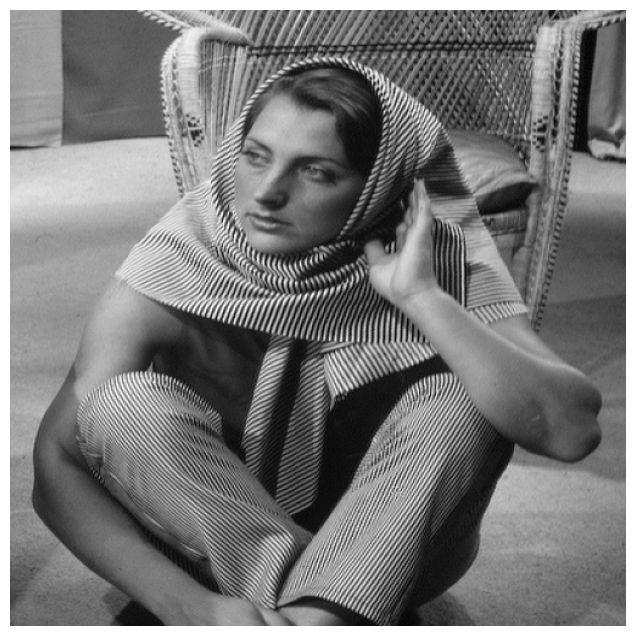

In [6]:
img_path = '/content/barbara.tif'
img_a = imageio.imread(img_path)
img_a = rgb2gray(img_a)
print('Original Data_type is {}'.format(img_a.dtype))
print('Data_type is', img_a.dtype)
print('Image Size is {}'.format(img_a.shape))
print('Image min and max are ({}, {})'.format(img_a.min(),img_a.max()))
#################################################
plt.figure(figsize=(8,8))
plt.imshow(img_a, cmap='gray')
plt.axis('off')
plt.show()

##(b)[**0.5 Points**] Show Corrupted Image.


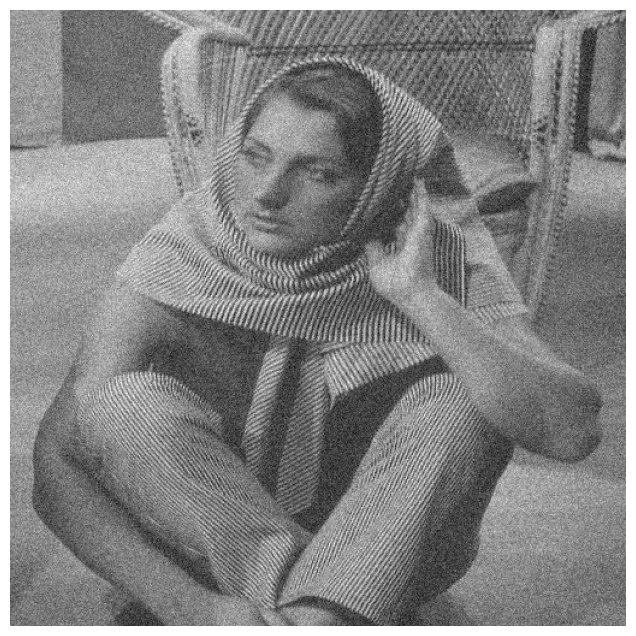

In [7]:
img_b = make_noisy("gauss", img_a)

plt.figure(figsize=(8,8))
plt.imshow(img_b, cmap='gray')
plt.axis('off')
plt.show()

##(c)[**12 Points**] Show Filtered Image from your Bilateral Function


91.42857142857143
370.9237829761054
40.05976856141938


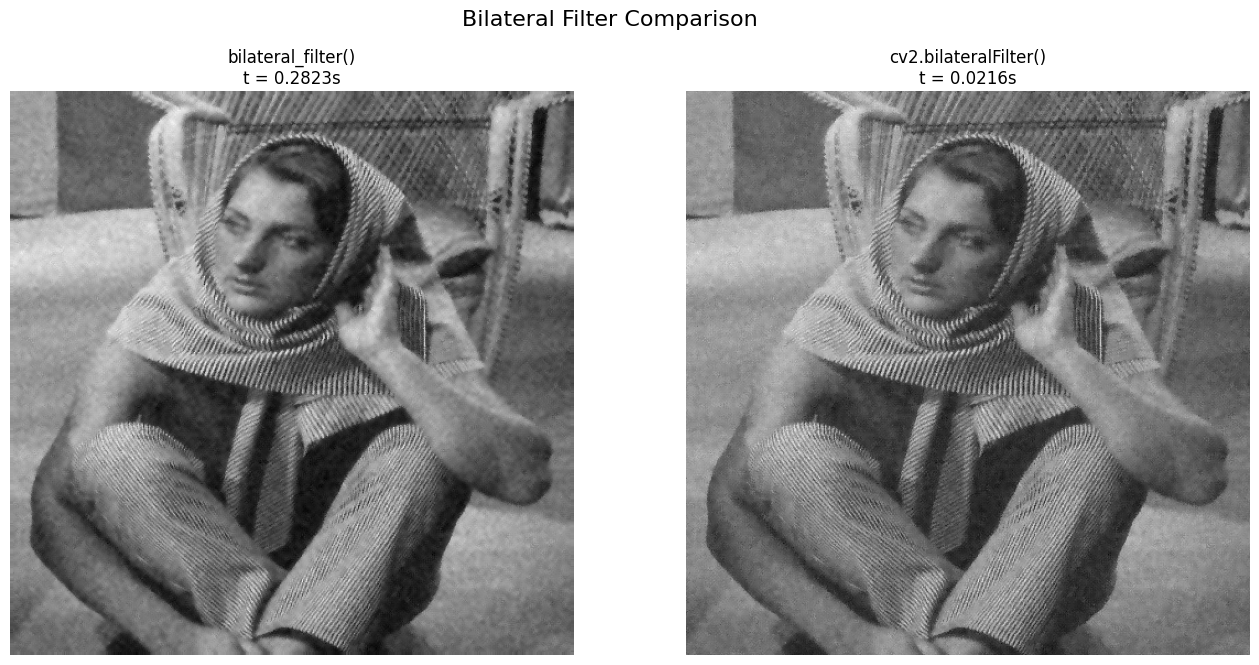

In [53]:
## img_b is corrupted image
(s1,s2) = img_b.shape
sigma_space = (min(s1,s2)/5.6) ### Modified according to part-d
print(sigma_space)
img_min = img_b.min()
img_max = img_b.max()
range_intensity = img_max - img_min
print(range_intensity)
sigma_int = (0.108*range_intensity) ### Modified according to part-d
print(sigma_int)
w_size = (8,8,8)

now = time.time()
# smaller value taken for window_size as window is taken as squares here while cv2 takes circular windows with size as diameter
img_c = bilateral_filter(img_b, 5, sigma_int, sigma_space)
bilateral_filter_end = time.time() - now

now = time.time()
img_d = cv.bilateralFilter(img_b.astype(np.float32), 7, sigma_int, sigma_space)
bilateralFilter_end = time.time() - now

plt.figure(figsize=(16,8))
plt.suptitle("Bilateral Filter Comparison", y=0.95, fontsize=16)
plt.subplot(121)
plt.title(f"bilateral_filter()\nt = {bilateral_filter_end:.4f}s")
plt.imshow(img_c, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.title(f"cv2.bilateralFilter()\nt = {bilateralFilter_end:.4f}s")
plt.imshow(img_d, cmap='gray')
plt.axis('off')
plt.show()

##(d)[**7.5 Points**] Print RMSE value between original image and Filtered image for following parameters settings:**[1.5 point each]**
1. Optimal $\sigma_{space}^*$ and $\sigma_{intensity}^*$.
2. $0.9*\sigma_{space}^*$ and $\sigma_{intensity}^*$.
3. $1.1*\sigma_{space}^*$ and $\sigma_{intensity}^*$.
4. $\sigma_{space}^*$ and $0.9*\sigma_{intensity}^*$.
5. $\sigma_{space}^*$ and $1.1*\sigma_{intensity}^*$.


In [54]:
def RMSD(original_image, filtered_image):
    return np.sqrt(np.sum(np.power(original_image - filtered_image, 2).flatten()) / (original_image.shape[0] * original_image.shape[1]))


print("1.", RMSD(img_a, bilateral_filter(img_a, 5, sigma_int, sigma_space)))
print("2.", RMSD(img_a, bilateral_filter(img_a, 5, 0.9 * sigma_int, sigma_space)))
print("3.", RMSD(img_a, bilateral_filter(img_a, 5, 1.1 * sigma_int, sigma_space)))
print("4.", RMSD(img_a, bilateral_filter(img_a, 5, sigma_int, 0.9 * sigma_space)))
print("5.", RMSD(img_a, bilateral_filter(img_a, 5, sigma_int, 1.1 * sigma_space)))

1. 13.243877795931791
2. 12.199093307852673
3. 14.171168483413473
4. 13.24382792056382
5. 13.243914709922565
